In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor

In [ ]:
df = pd.read_csv('data/autos.csv')

In [ ]:
df.head()

index          dateCrawled                            name  seller  \
0      0  2016-03-24 11:52:17                      Golf_3_1.6  privat   
1      1  2016-03-24 10:58:45            A5_Sportback_2.7_Tdi  privat   
2      2  2016-03-14 12:52:21  Jeep_Grand_Cherokee_"Overland"  privat   
3      3  2016-03-17 16:54:04              GOLF_4_1_4__3TÜRER  privat   
4      4  2016-03-31 17:25:20  Skoda_Fabia_1.4_TDI_PD_Classic  privat   

  offerType  price abtest vehicleType  yearOfRegistration    gearbox  ...  \
0   Angebot    480   test         NaN                1993    manuell  ...   
1   Angebot  18300   test       coupe                2011    manuell  ...   
2   Angebot   9800   test         suv                2004  automatik  ...   
3   Angebot   1500   test  kleinwagen                2001    manuell  ...   
4   Angebot   3600   test  kleinwagen                2008    manuell  ...   

   model kilometer  monthOfRegistration  fuelType       brand  \
0   golf    150000                    0    benzin  volkswagen   
1    NaN    125000                    5    diesel        audi   
2  grand    125000                    8    diesel        jeep   
3   golf    150000                    6    benzin  volkswagen   
4  fabia     90000                    7    diesel       skoda   

  notRepairedDamage          dateCreated nrOfPictures  postalCode  \
0               NaN  2016-03-24 00:00:00            0       70435   
1                ja  2016-03-24 00:00:00            0       66954   
2               NaN  2016-03-14 00:00:00            0       90480   
3              nein  2016-03-17 00:00:00            0       91074   
4              nein  2016-03-31 00:00:00            0       60437   

              lastSeen  
0  2016-04-07 03:16:57  
1  2016-04-07 01:46:50  
2  2016-04-05 12:47:46  
3  2016-03-17 17:40:17  
4  2016-04-06 10:17:21  

[5 rows x 21 columns]

In [ ]:
df = df.drop('index', axis = 1)
print(df.columns)

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'nrOfPictures', 'postalCode',
       'lastSeen'],
      dtype='object')


### Обработаем признак 'postalCode' (первые 3 цифры указывают на город)

In [ ]:
df['postalCode'] = df['postalCode'].astype(str).str[:3]

In [ ]:
counts_postal = df['postalCode'].value_counts()
df['postalCode'] = df['postalCode'].apply(lambda x: 'other' if counts_postal[x] <= 10 else x)

In [ ]:
df['postalCode'].nunique()

710

# Разделим все признаки на категориальные и числовые

In [ ]:
object_type = df['dateCrawled'].dtype
num_cols = []
object_cols = []
for col in df.columns:
    if df[col].dtype is object_type:
        object_cols.append(col)
    else:
        num_cols.append(col)

In [ ]:
object_cols

['dateCrawled',
 'name',
 'seller',
 'offerType',
 'abtest',
 'vehicleType',
 'gearbox',
 'model',
 'fuelType',
 'brand',
 'notRepairedDamage',
 'dateCreated',
 'postalCode',
 'lastSeen']

In [ ]:
num_cols

['price',
 'yearOfRegistration',
 'powerPS',
 'kilometer',
 'monthOfRegistration',
 'nrOfPictures']

In [ ]:
df['dateCrawled'] = pd.to_datetime(df['dateCrawled'])
df['dateCreated'] = pd.to_datetime(df['dateCreated'])
# df['lastSeen'] = pd.to_datetime(df['lastSeen'])

### Признак 'nrOfPictures' бесполезен (он представлен только одним значением)

In [ ]:
df.nunique()

dateCrawled            280500
name                   233531
seller                      2
offerType                   2
price                    5597
abtest                      2
vehicleType                 8
yearOfRegistration        155
gearbox                     2
powerPS                   794
model                     251
kilometer                  13
monthOfRegistration        13
fuelType                    7
brand                      40
notRepairedDamage           2
dateCreated               114
nrOfPictures                1
postalCode                710
lastSeen               182806
dtype: int64

In [ ]:
df.drop('nrOfPictures', axis=1, inplace=True)
del num_cols[num_cols.index('nrOfPictures')]

#**Фильтр**

In [ ]:
# df = df[df['yearOfRegistration'] >= 1994]
df = df[2016 - df['yearOfRegistration'] <= 30]
df = df[df['powerPS'] <= 500]

### Обработка дубликатов

In [ ]:
df.duplicated().sum()

4

In [ ]:
df = df.drop_duplicates(df.columns)

## Обработка выбросов

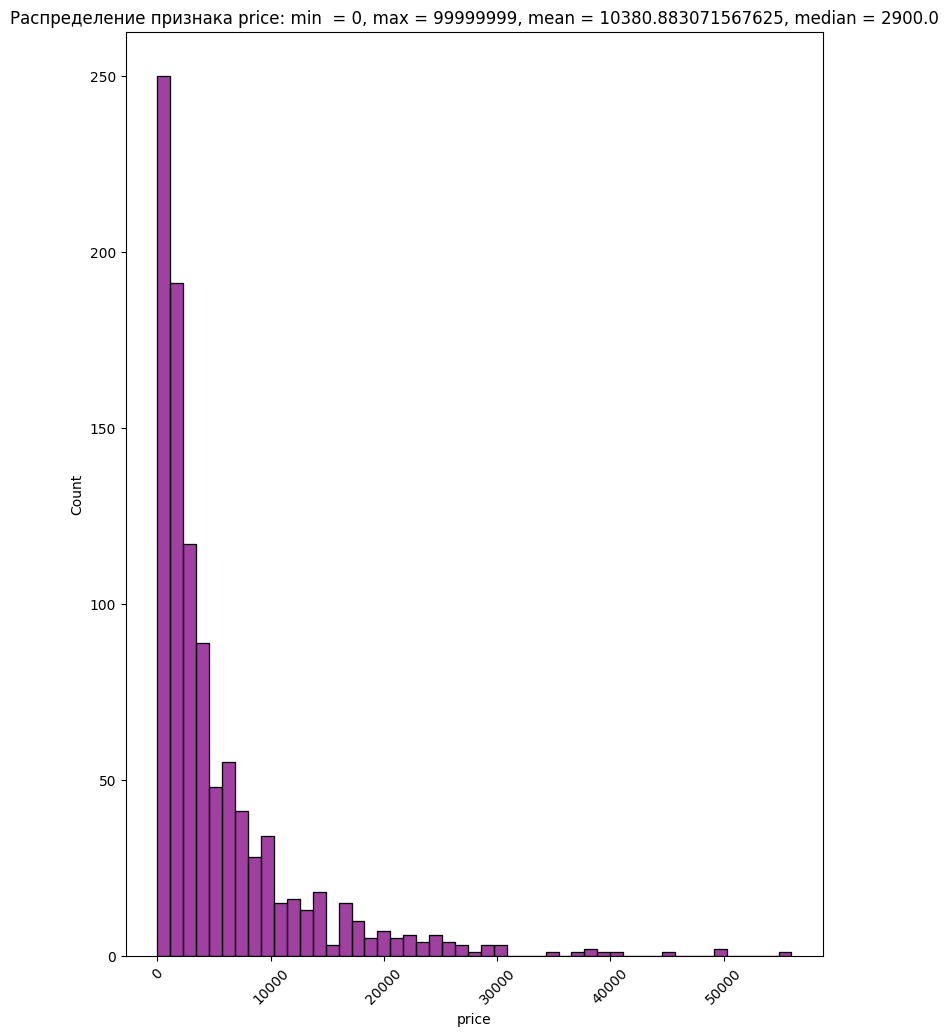

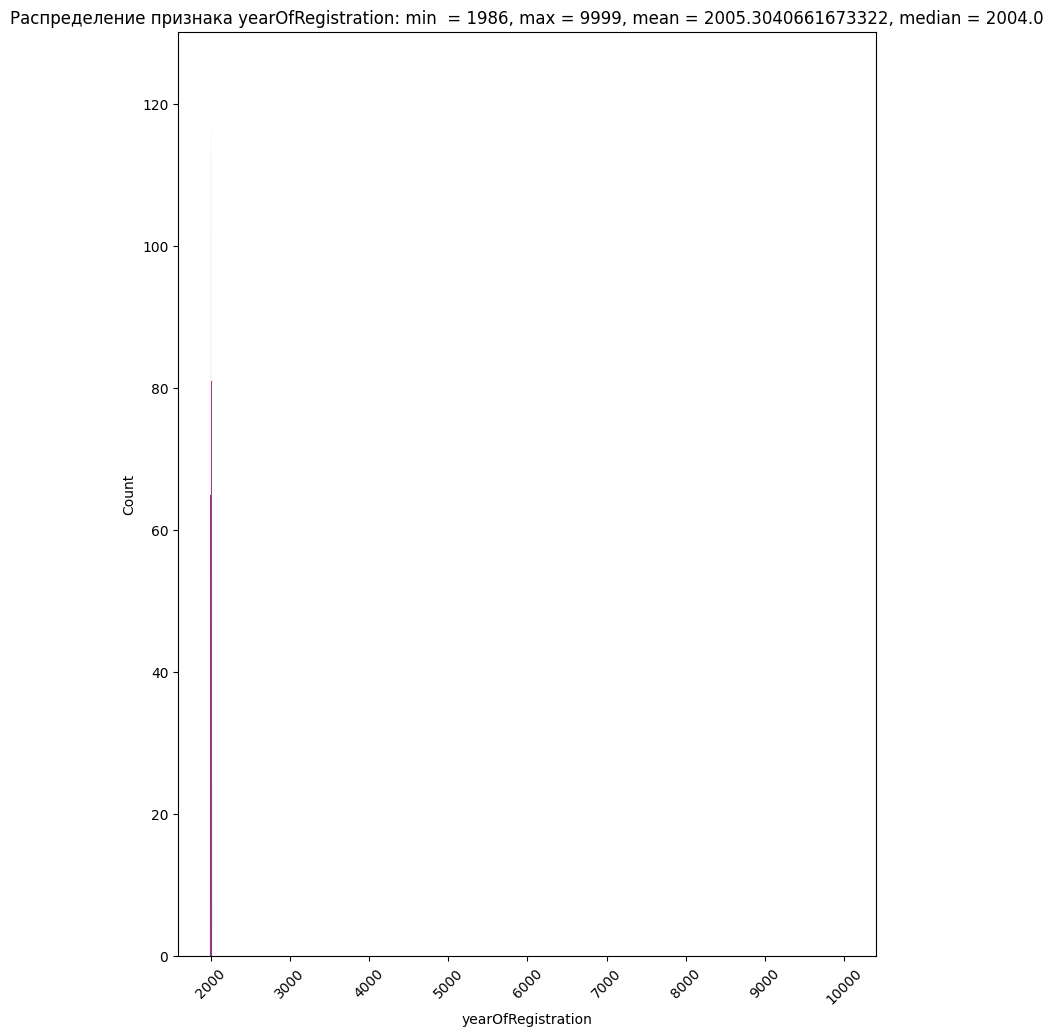

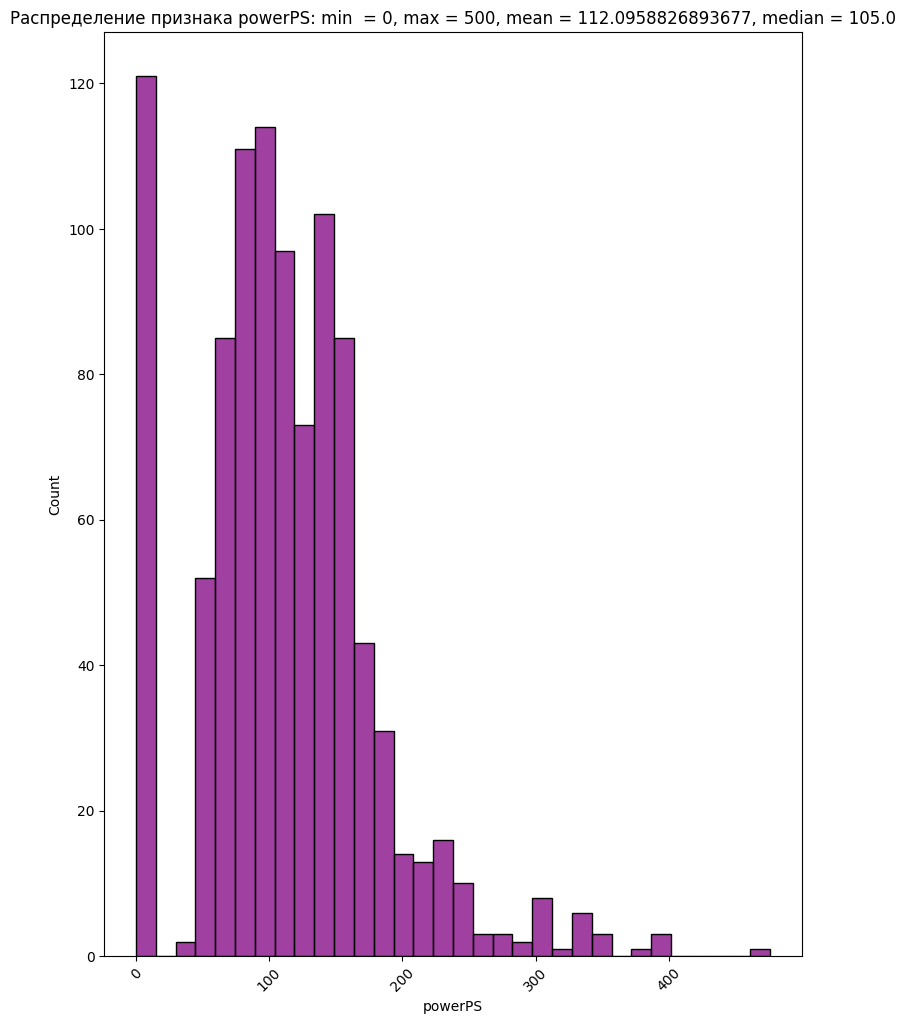

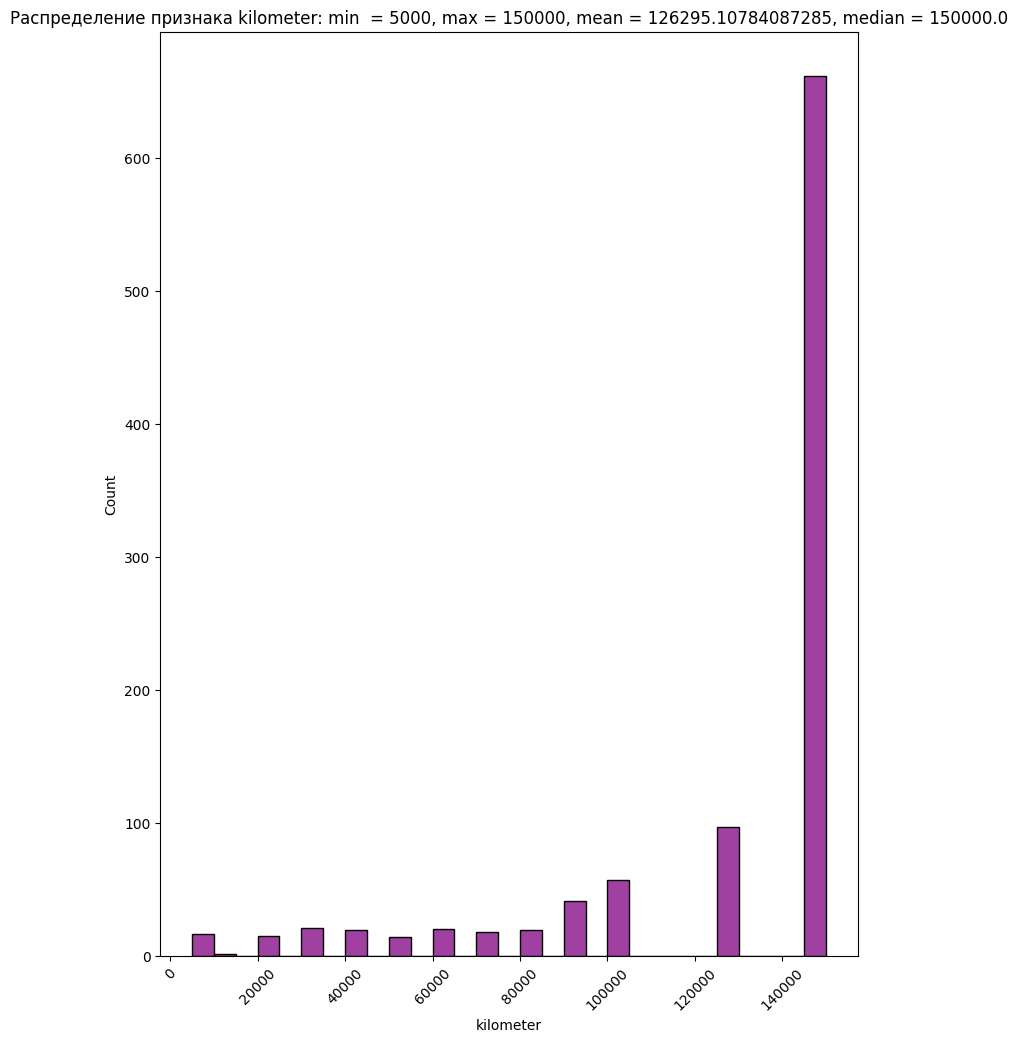

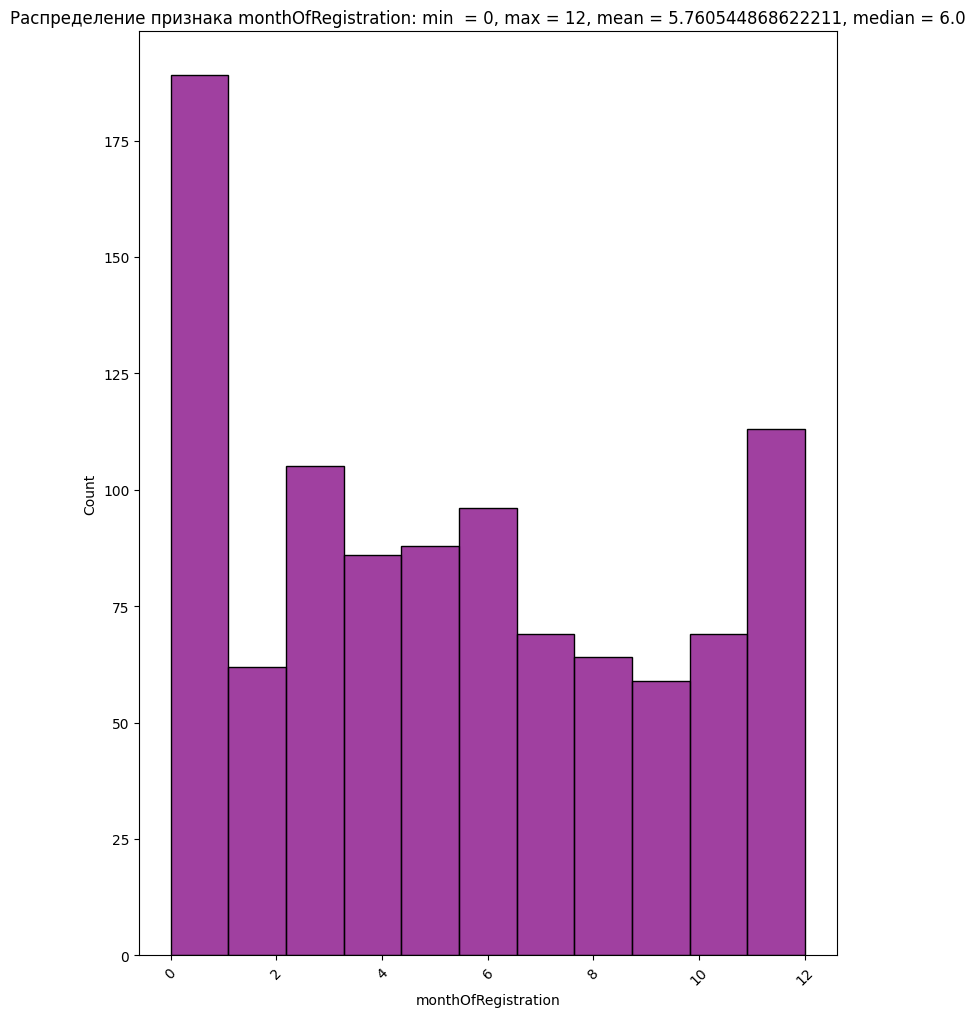

In [ ]:
for col in num_cols:
    plt.figure(figsize=(9,12))
    x = df[col]
    sns.histplot(x = x.sample(1000), color='purple')
    plt.xticks(rotation = 45)
    plt.title(f'Распределение признака {col}: min  = {x.min()}, max = {x.max()}, mean = {x.mean()}, median = {x.median()}');

### Выбросы или аномалии есть в признаке 'price'. Выбросы определённо есть в 'PowerPS', 'yearOfRegistration'

In [ ]:
df.shape

(363684, 19)

In [ ]:
df = df[(df['yearOfRegistration'] < 2017) & (df['yearOfRegistration'] >= 1886)]
df = df[df['powerPS'] < 2028]

In [ ]:
df.shape

(349037, 19)

In [ ]:
(df['price'] == 0).sum() #?????????

9453

### Попробуем обработать 'price'

In [ ]:
df['price'] = np.log1p(df['price'])

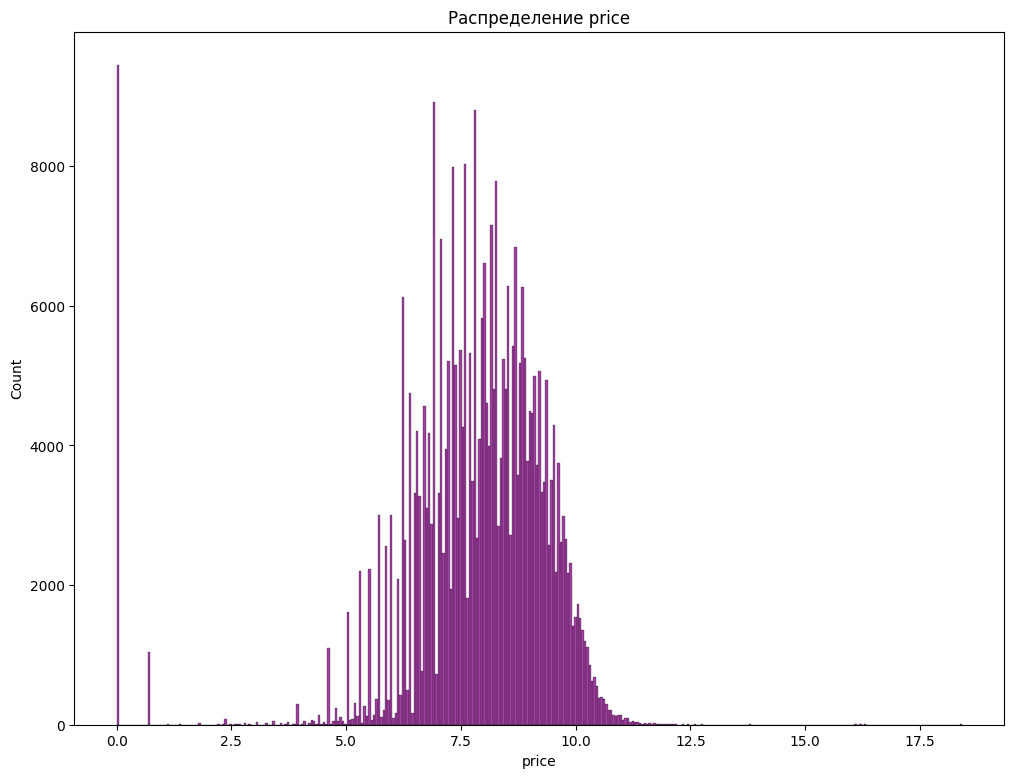

In [ ]:
plt.figure(figsize=(12,9))
sns.histplot(x = df['price'], color='purple')
plt.title('Распределение price');

In [ ]:
# df = df[(df['price'] > df['price'].quantile(0.01)) & (df['price'] < df['price'].quantile(0.99))]


Q1 = df["price"].quantile(0.25)
Q3 = df["price"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["price"] >= Q1 - 1.5 * IQR) & (df["price"] <= Q3 + 1.5 * IQR)]


<ipython-input-25-47379f949816>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = np.expm1(df['price'])


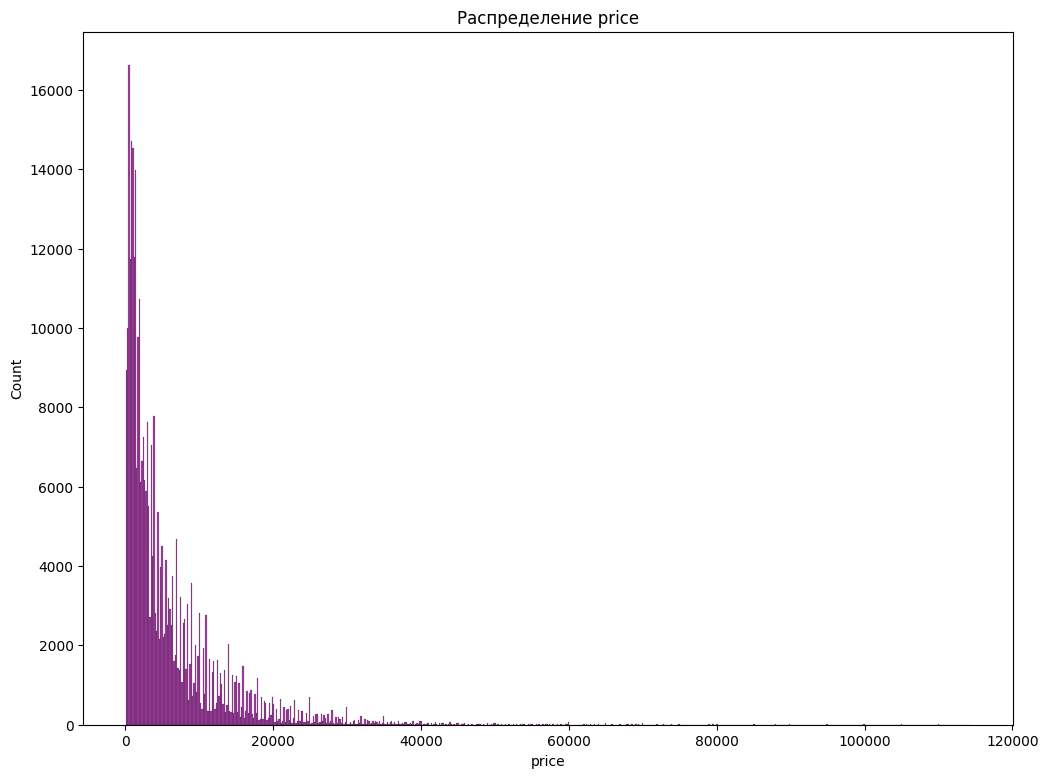

In [ ]:
df['price'] = np.expm1(df['price'])
plt.figure(figsize=(12,9))
sns.histplot(x = df['price'], color='purple')
plt.title('Распределение price');

### Визуализация

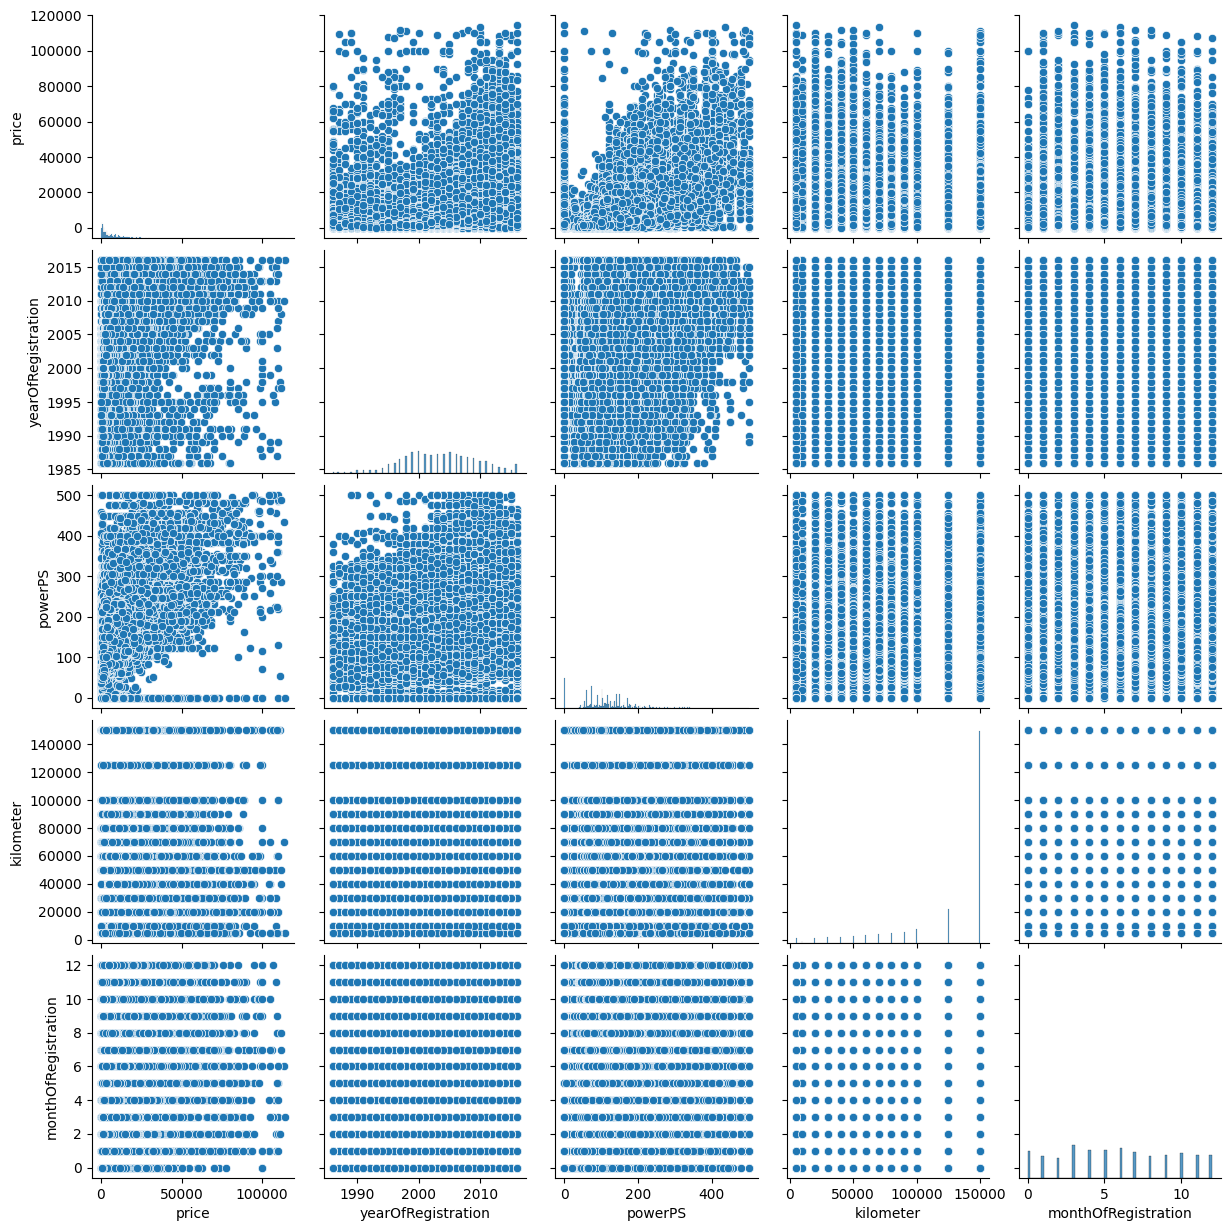

In [ ]:
sns.pairplot(df)

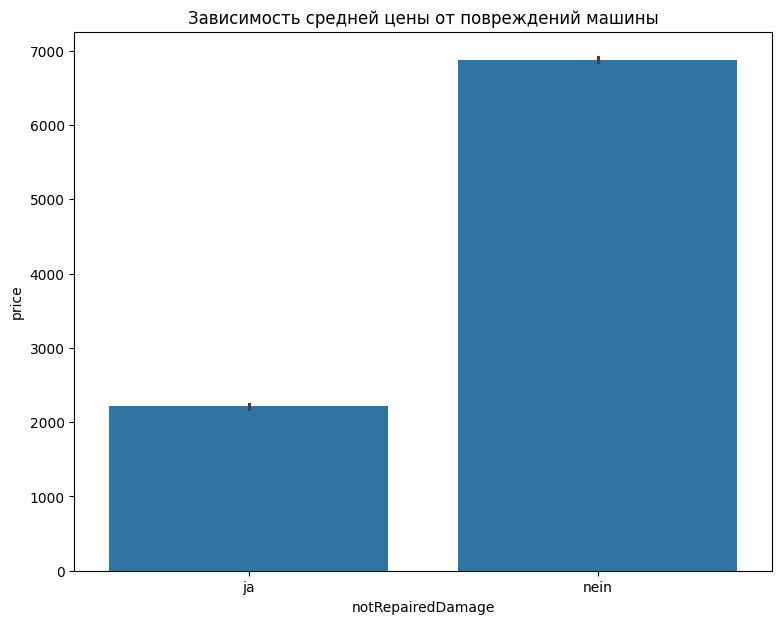

In [ ]:
plt.figure(figsize=(9,7))
sns.barplot(data=df, x='notRepairedDamage', y ='price', estimator='mean')
plt.title('Зависимость средней цены от повреждений машины');

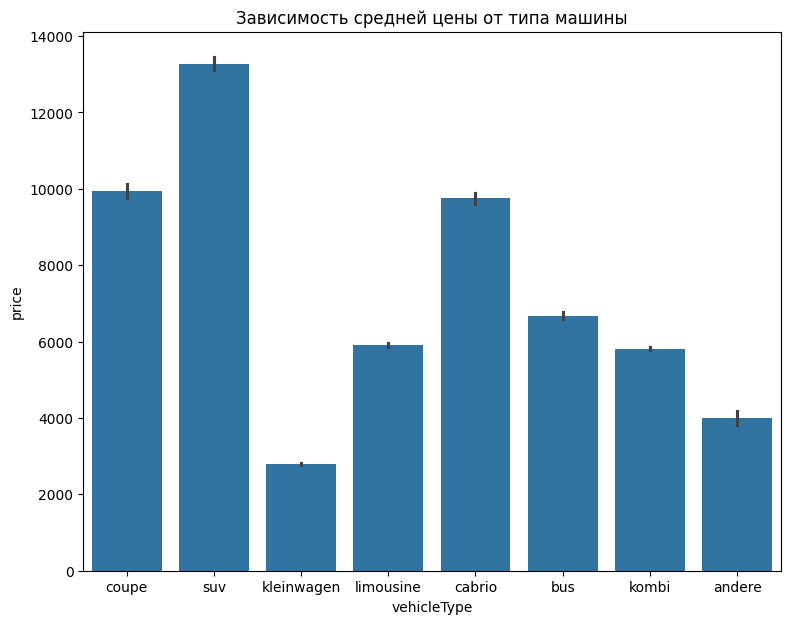

In [ ]:
plt.figure(figsize=(9,7))
sns.barplot(data=df, x='vehicleType', y ='price', estimator='mean')
plt.title('Зависимость средней цены от типа машины');

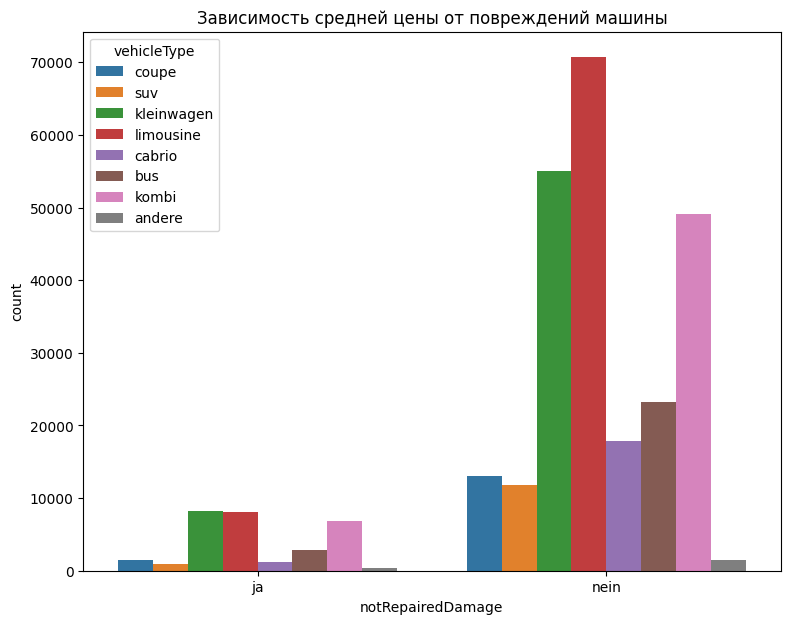

In [ ]:
plt.figure(figsize=(9,7))
sns.countplot(data=df, x='notRepairedDamage', hue='vehicleType')
plt.title('Зависимость средней цены от повреждений машины');

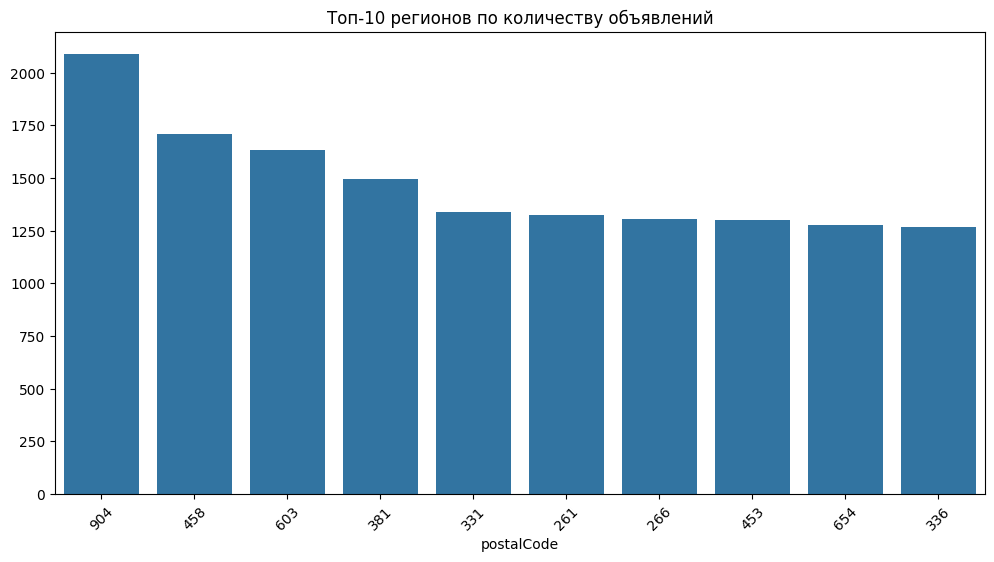

In [ ]:
top_postal = df['postalCode'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_postal.index, y=top_postal.values)
plt.title('Топ-10 регионов по количеству объявлений')
plt.xticks(rotation=45)
plt.show()

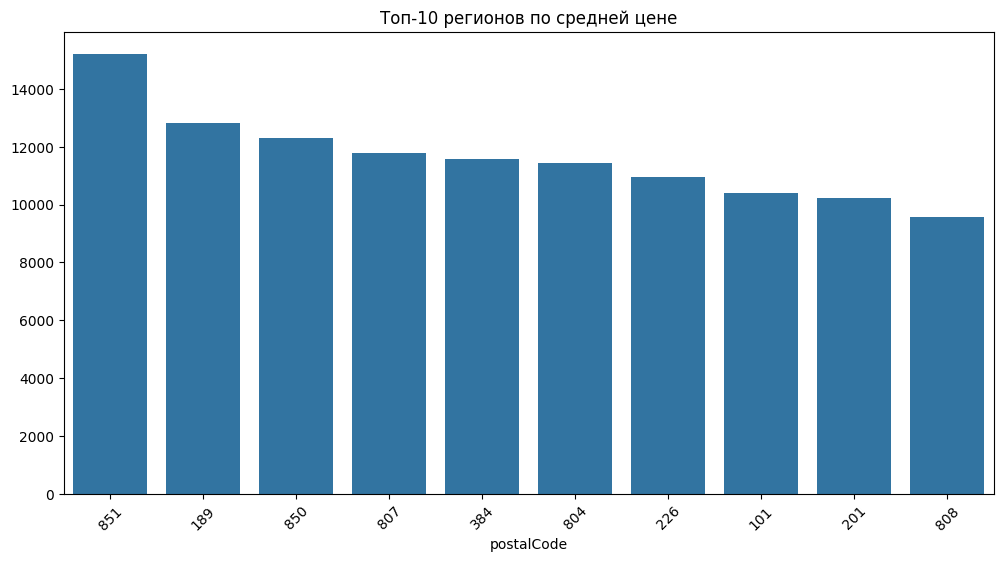

In [ ]:
top_postal = df.groupby('postalCode')['price'].mean().sort_values(ascending=False)[:10]
plt.figure(figsize=(12, 6))
sns.barplot(x=top_postal.index, y=top_postal.values)
plt.title('Топ-10 регионов по средней цене')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df.columns

Index(['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'powerPS', 'model',
       'kilometer', 'monthOfRegistration', 'fuelType', 'brand',
       'notRepairedDamage', 'dateCreated', 'postalCode', 'lastSeen'],
      dtype='object')

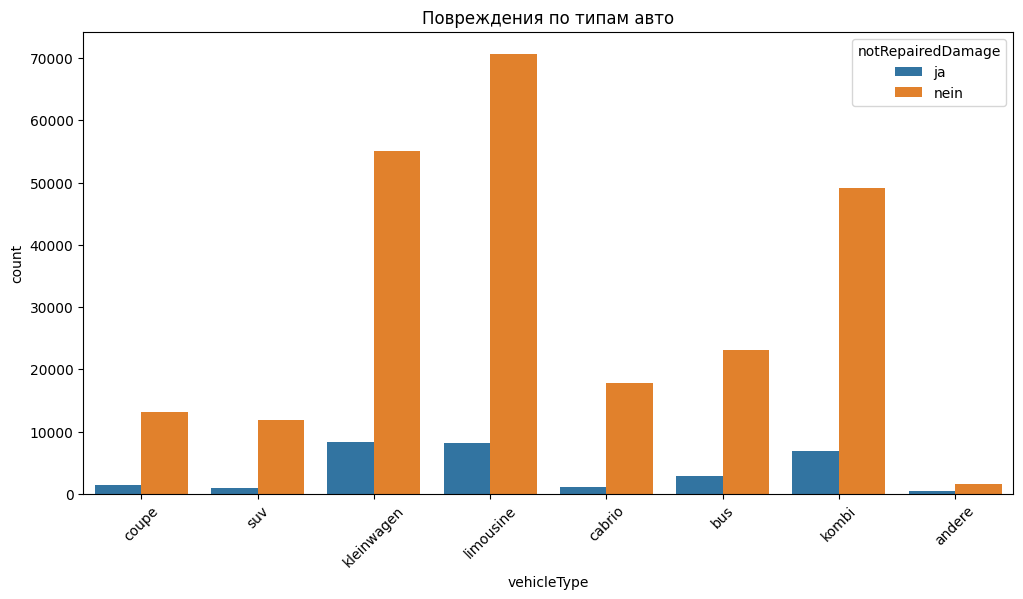

In [ ]:
plt.figure(figsize=(12, 6))
sns.countplot(x='vehicleType', hue='notRepairedDamage', data=df)
plt.title('Повреждения по типам авто')
plt.xticks(rotation=45)
plt.show()

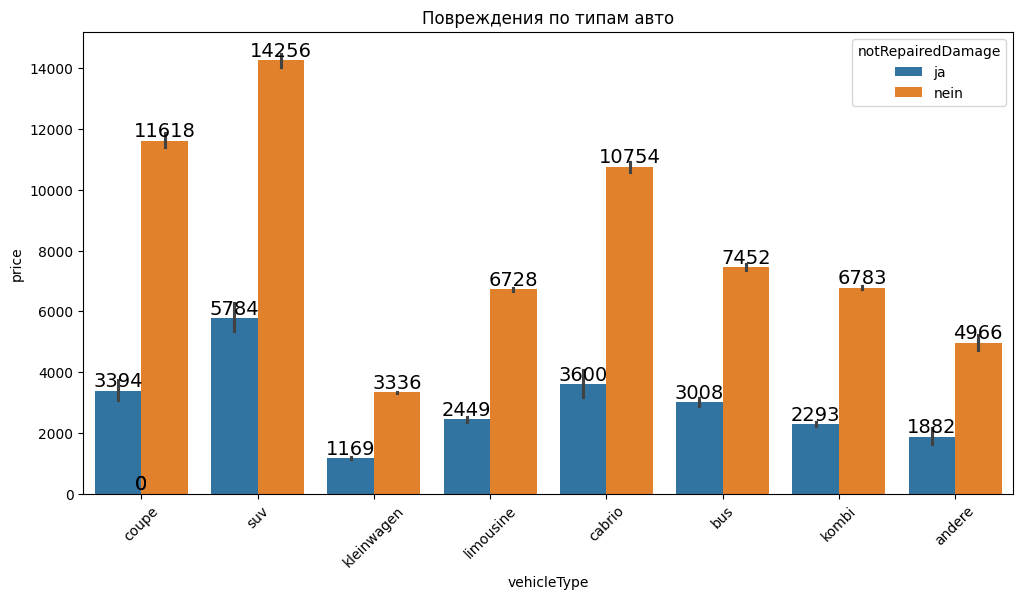

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='vehicleType', y='price', estimator='mean', hue='notRepairedDamage', data=df)
plt.title('Повреждения по типам авто')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{int(p.get_height())}',
        ha='center',
        va='bottom',
        fontsize=14,
        color='black'
    )
plt.xticks(rotation=45)
plt.show()

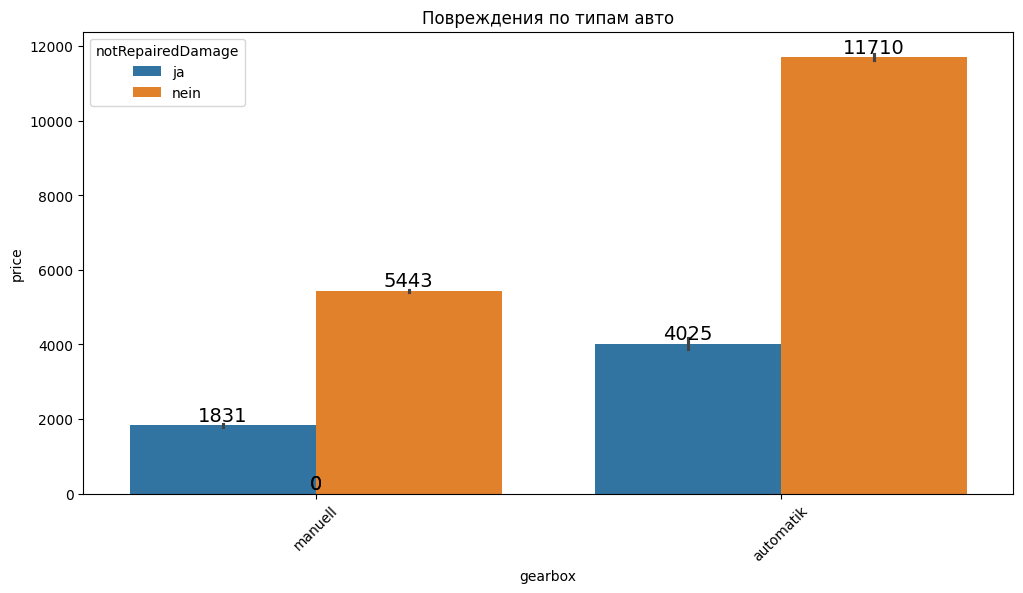

In [ ]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='gearbox', y='price', estimator='mean', hue='notRepairedDamage', data=df)
plt.title('Повреждения по типам авто')

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{int(p.get_height())}',
        ha='center',
        va='bottom',
        fontsize=14,
        color='black'
    )
plt.xticks(rotation=45)
plt.show()

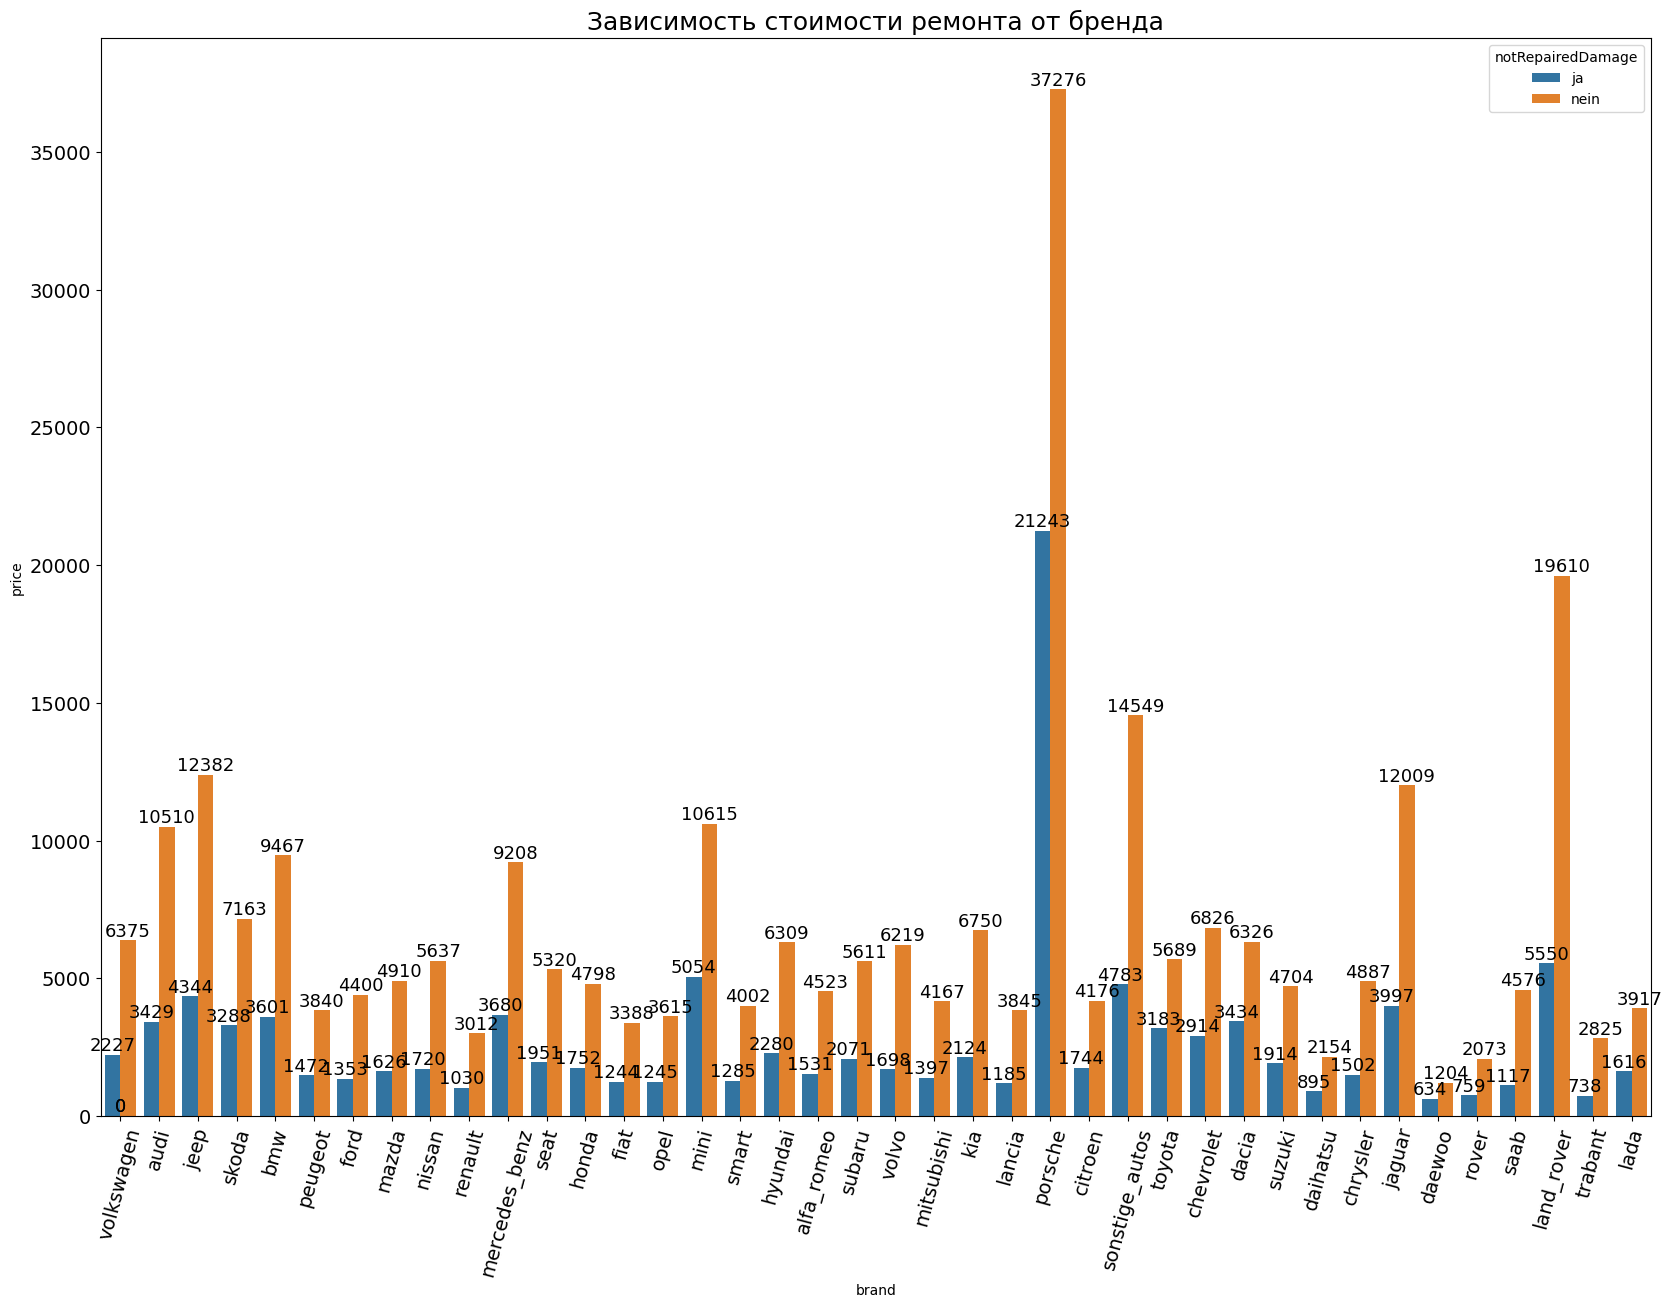

In [ ]:
plt.figure(figsize=(20, 14))
ax = sns.barplot(x='brand', y='price', estimator='mean', hue='notRepairedDamage', data=df, errorbar=None)
plt.title('Зависимость стоимости ремонта от бренда', size=18)

ax.tick_params(axis='both', which='major', labelsize=14)

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{int(p.get_height())}',
        ha='center',
        va='bottom',
        fontsize=13,
        color='black'
    )
plt.xticks(rotation=75)
plt.show()

<ipython-input-37-e5e2790177af>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="brand", y="count", data=damaged_cars_by_brand, palette="coolwarm", errorbar=None)


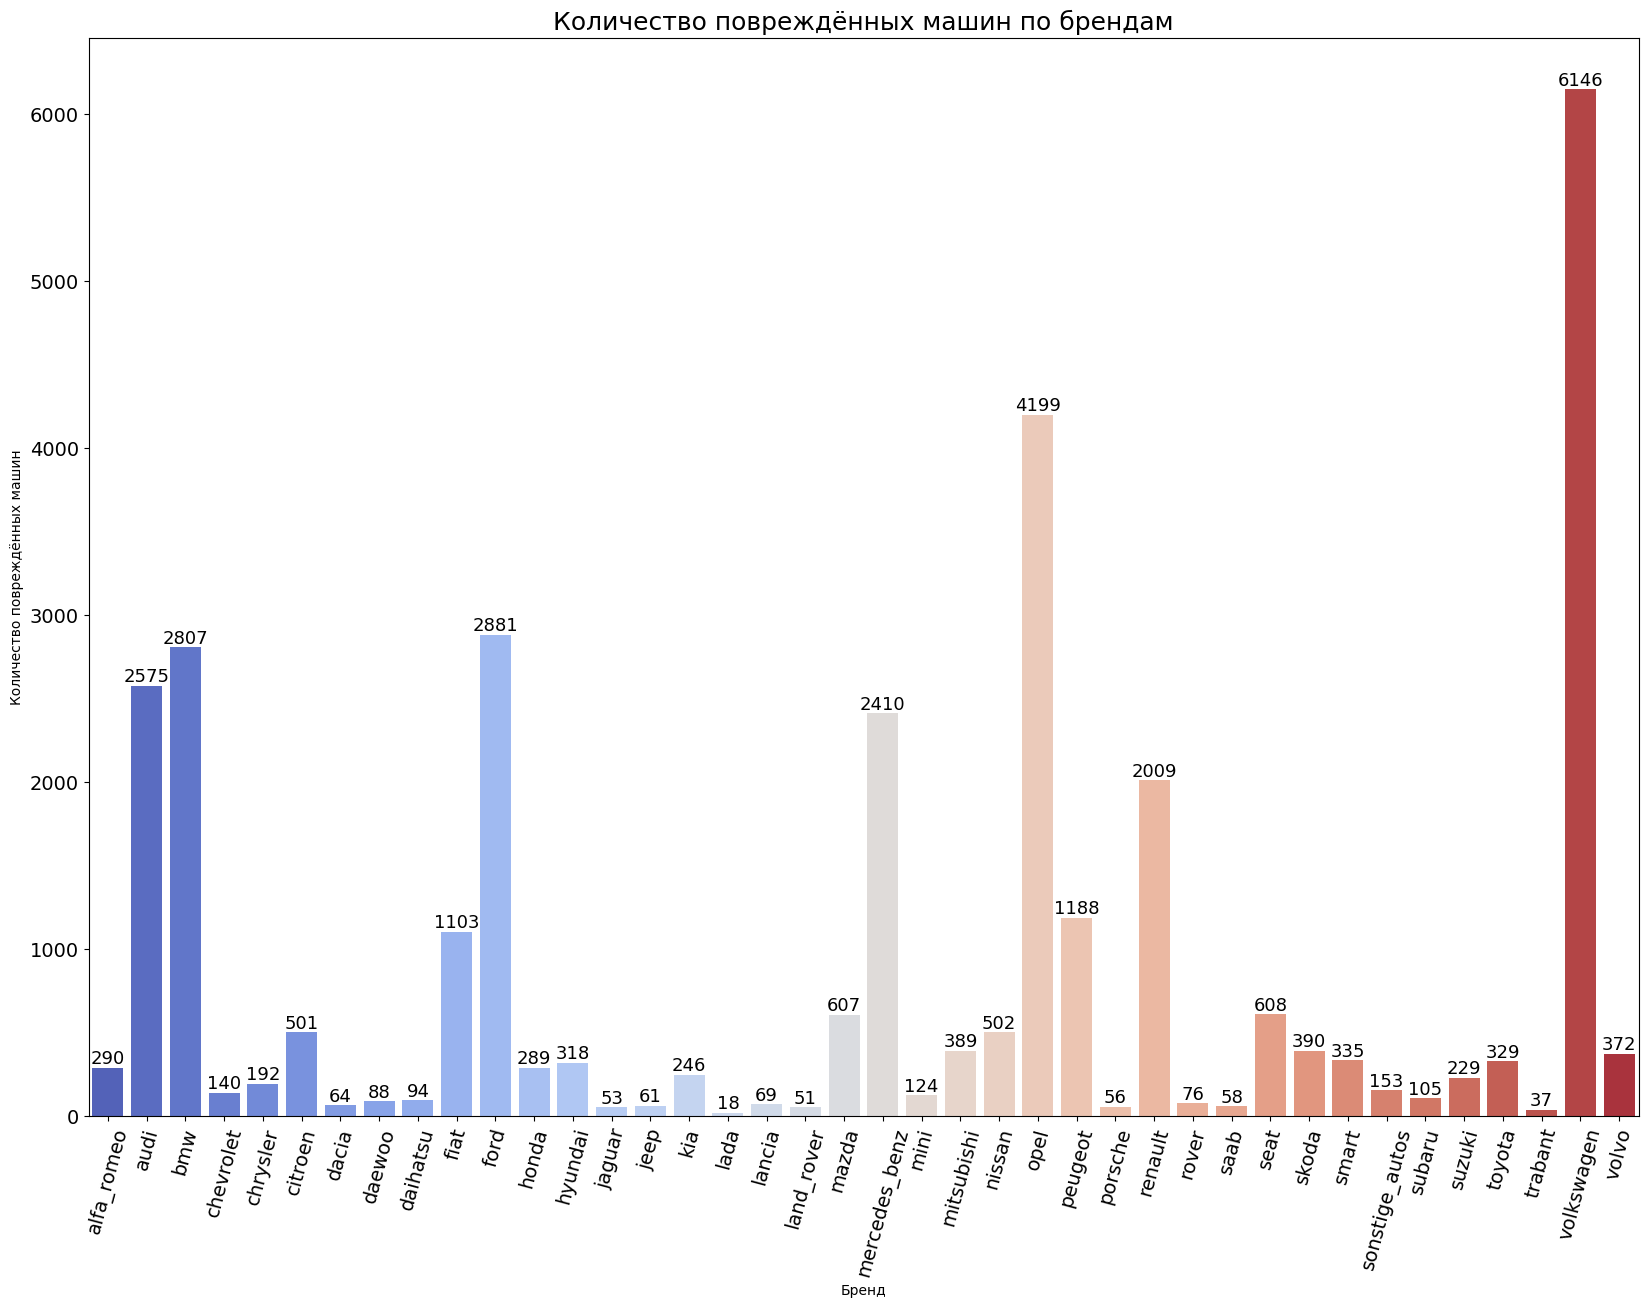

In [ ]:
# Группируем и считаем повреждённые машины по бренду
damaged_cars_by_brand = df[df["notRepairedDamage"] == "ja"].groupby("brand").size().reset_index(name="count")

# Строим график
plt.figure(figsize=(20, 14))
ax = sns.barplot(x="brand", y="count", data=damaged_cars_by_brand, palette="coolwarm", errorbar=None)

plt.title("Количество повреждённых машин по брендам", size=18)
ax.tick_params(axis="both", which="major", labelsize=14)

# Подписываем столбцы
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2.,
        p.get_height(),
        f'{int(p.get_height())}',
        ha='center',
        va='bottom',
        fontsize=13,
        color='black'
    )

plt.xticks(rotation=75)
plt.xlabel("Бренд")
plt.ylabel("Количество повреждённых машин")
plt.show()

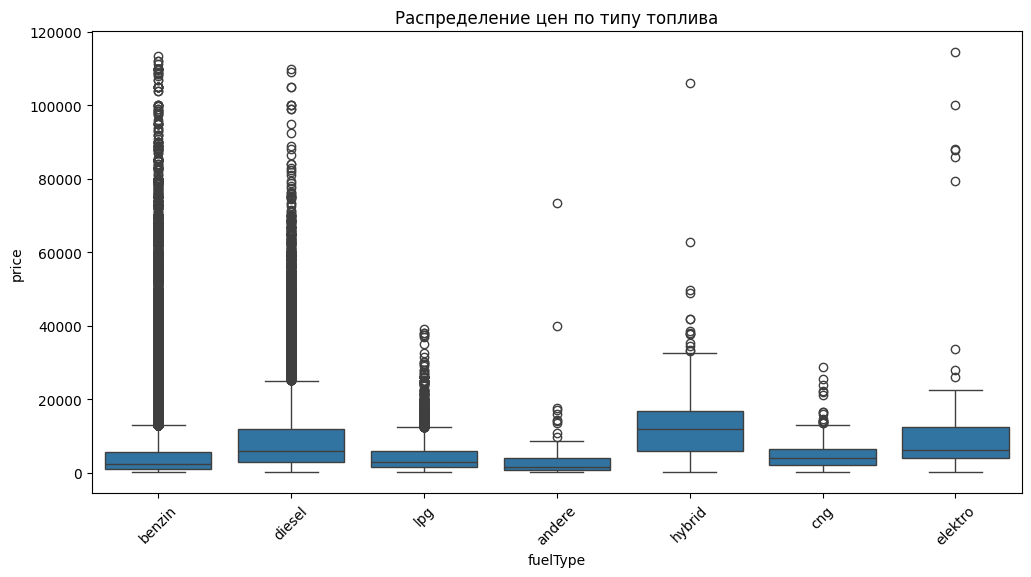

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='fuelType', y='price', data=df)
plt.title('Распределение цен по типу топлива')
plt.xticks(rotation=45)
plt.show()

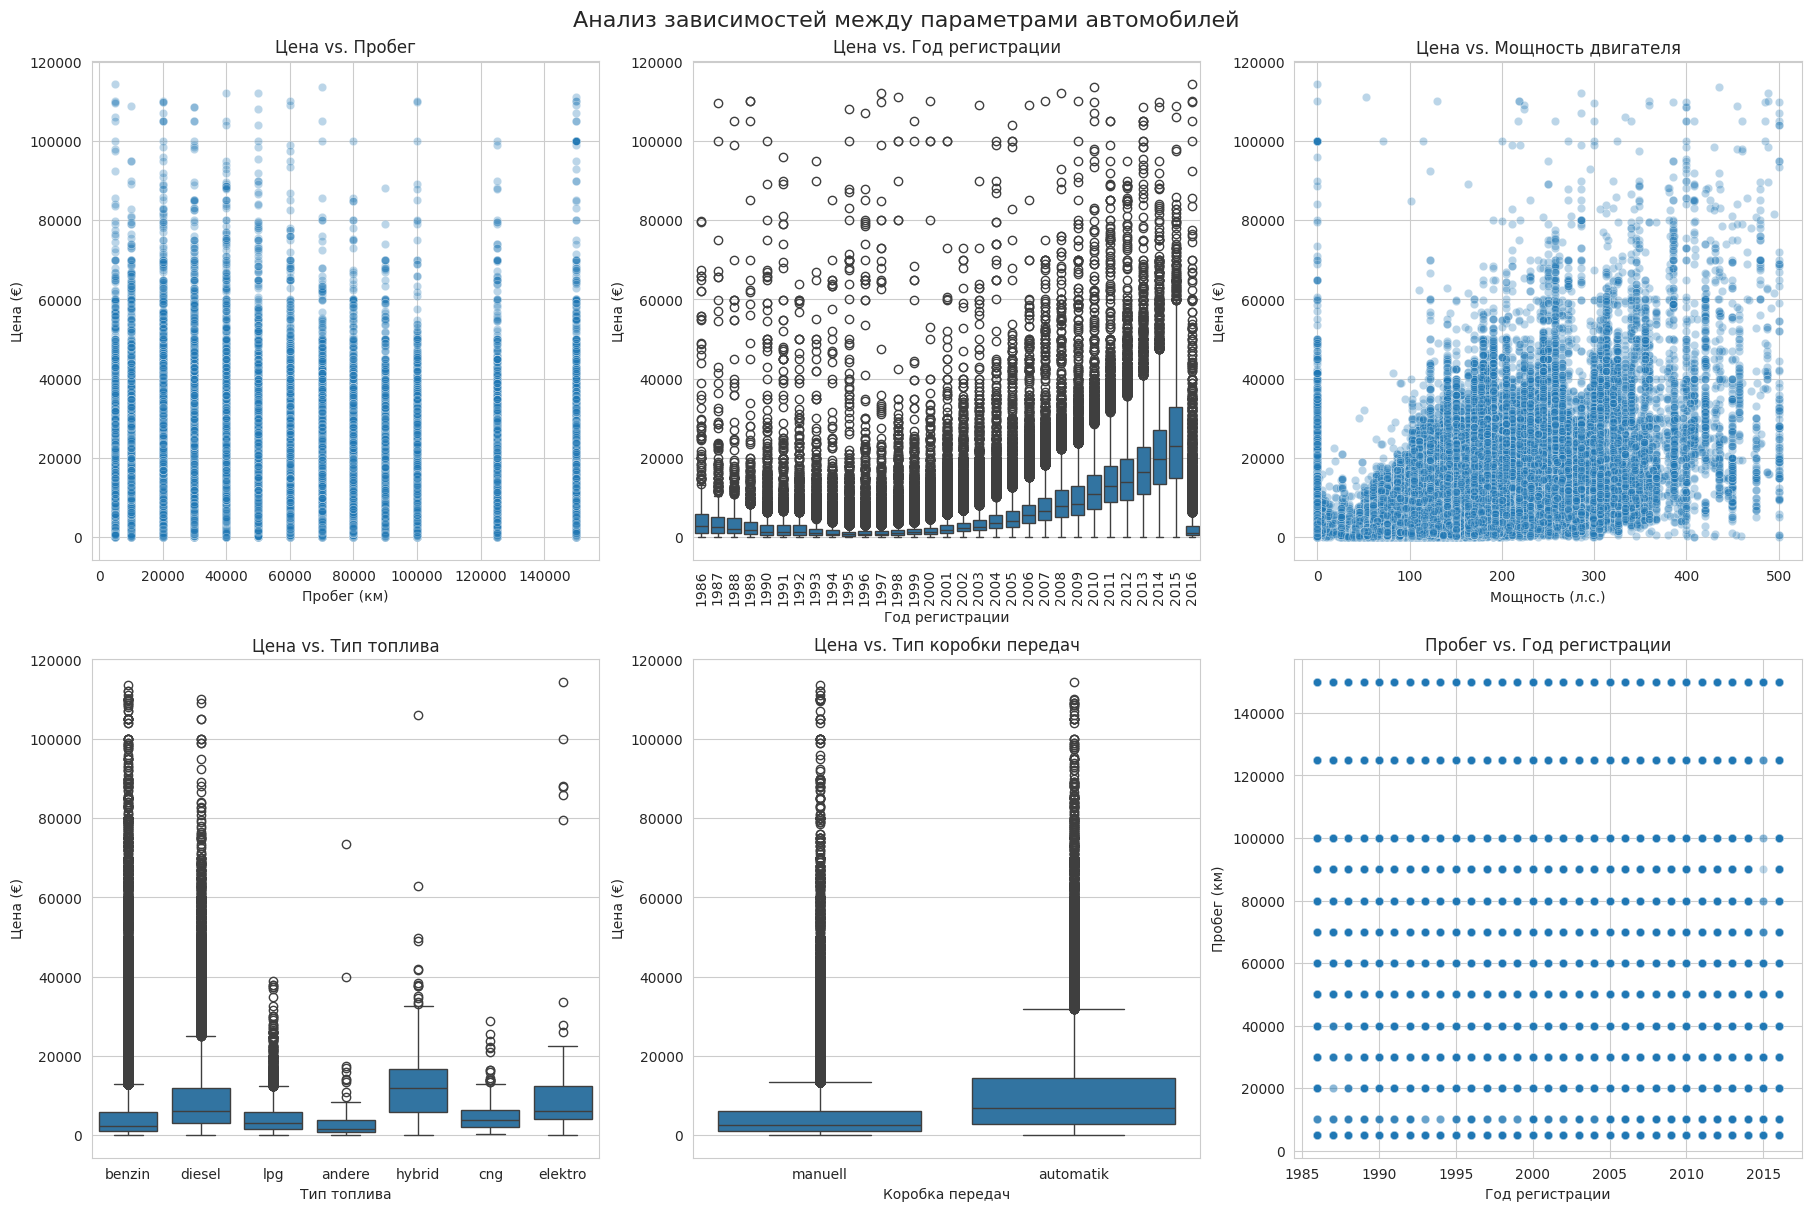

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
fig.suptitle("Анализ зависимостей между параметрами автомобилей", fontsize=16)

# 1. Цена vs. Пробег
sns.scatterplot(x=df["kilometer"], y=df["price"], alpha=0.3, ax=axes[0, 0])
axes[0, 0].set_title("Цена vs. Пробег")
axes[0, 0].set_xlabel("Пробег (км)")
axes[0, 0].set_ylabel("Цена (€)")

# 2. Цена vs. Год регистрации
sns.boxplot(x=df["yearOfRegistration"], y=df["price"], ax=axes[0, 1])
axes[0, 1].set_title("Цена vs. Год регистрации")
axes[0, 1].set_xlabel("Год регистрации")
axes[0, 1].set_ylabel("Цена (€)")
axes[0, 1].tick_params(axis='x', rotation=90)

# 3. Цена vs. Мощность двигателя
sns.scatterplot(x=df["powerPS"], y=df["price"], alpha=0.3, ax=axes[0, 2])
axes[0, 2].set_title("Цена vs. Мощность двигателя")
axes[0, 2].set_xlabel("Мощность (л.с.)")
axes[0, 2].set_ylabel("Цена (€)")

# 4. Цена vs. Тип топлива
sns.boxplot(x=df["fuelType"], y=df["price"], ax=axes[1, 0])
axes[1, 0].set_title("Цена vs. Тип топлива")
axes[1, 0].set_xlabel("Тип топлива")
axes[1, 0].set_ylabel("Цена (€)")

# 5. Цена vs. Тип коробки передач
sns.boxplot(x=df["gearbox"], y=df["price"], ax=axes[1, 1])
axes[1, 1].set_title("Цена vs. Тип коробки передач")
axes[1, 1].set_xlabel("Коробка передач")
axes[1, 1].set_ylabel("Цена (€)")

# 6. Пробег vs. Год регистрации
sns.scatterplot(x=df["yearOfRegistration"], y=df["kilometer"], alpha=0.3, ax=axes[1, 2])
axes[1, 2].set_title("Пробег vs. Год регистрации")
axes[1, 2].set_xlabel("Год регистрации")
axes[1, 2].set_ylabel("Пробег (км)")

plt.show()

<ipython-input-40-7df056729f25>:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(brand_counts.index, rotation=90)
<ipython-input-40-7df056729f25>:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2, 1].set_xticklabels(axes[2, 1].get_xticklabels(), rotation=90)


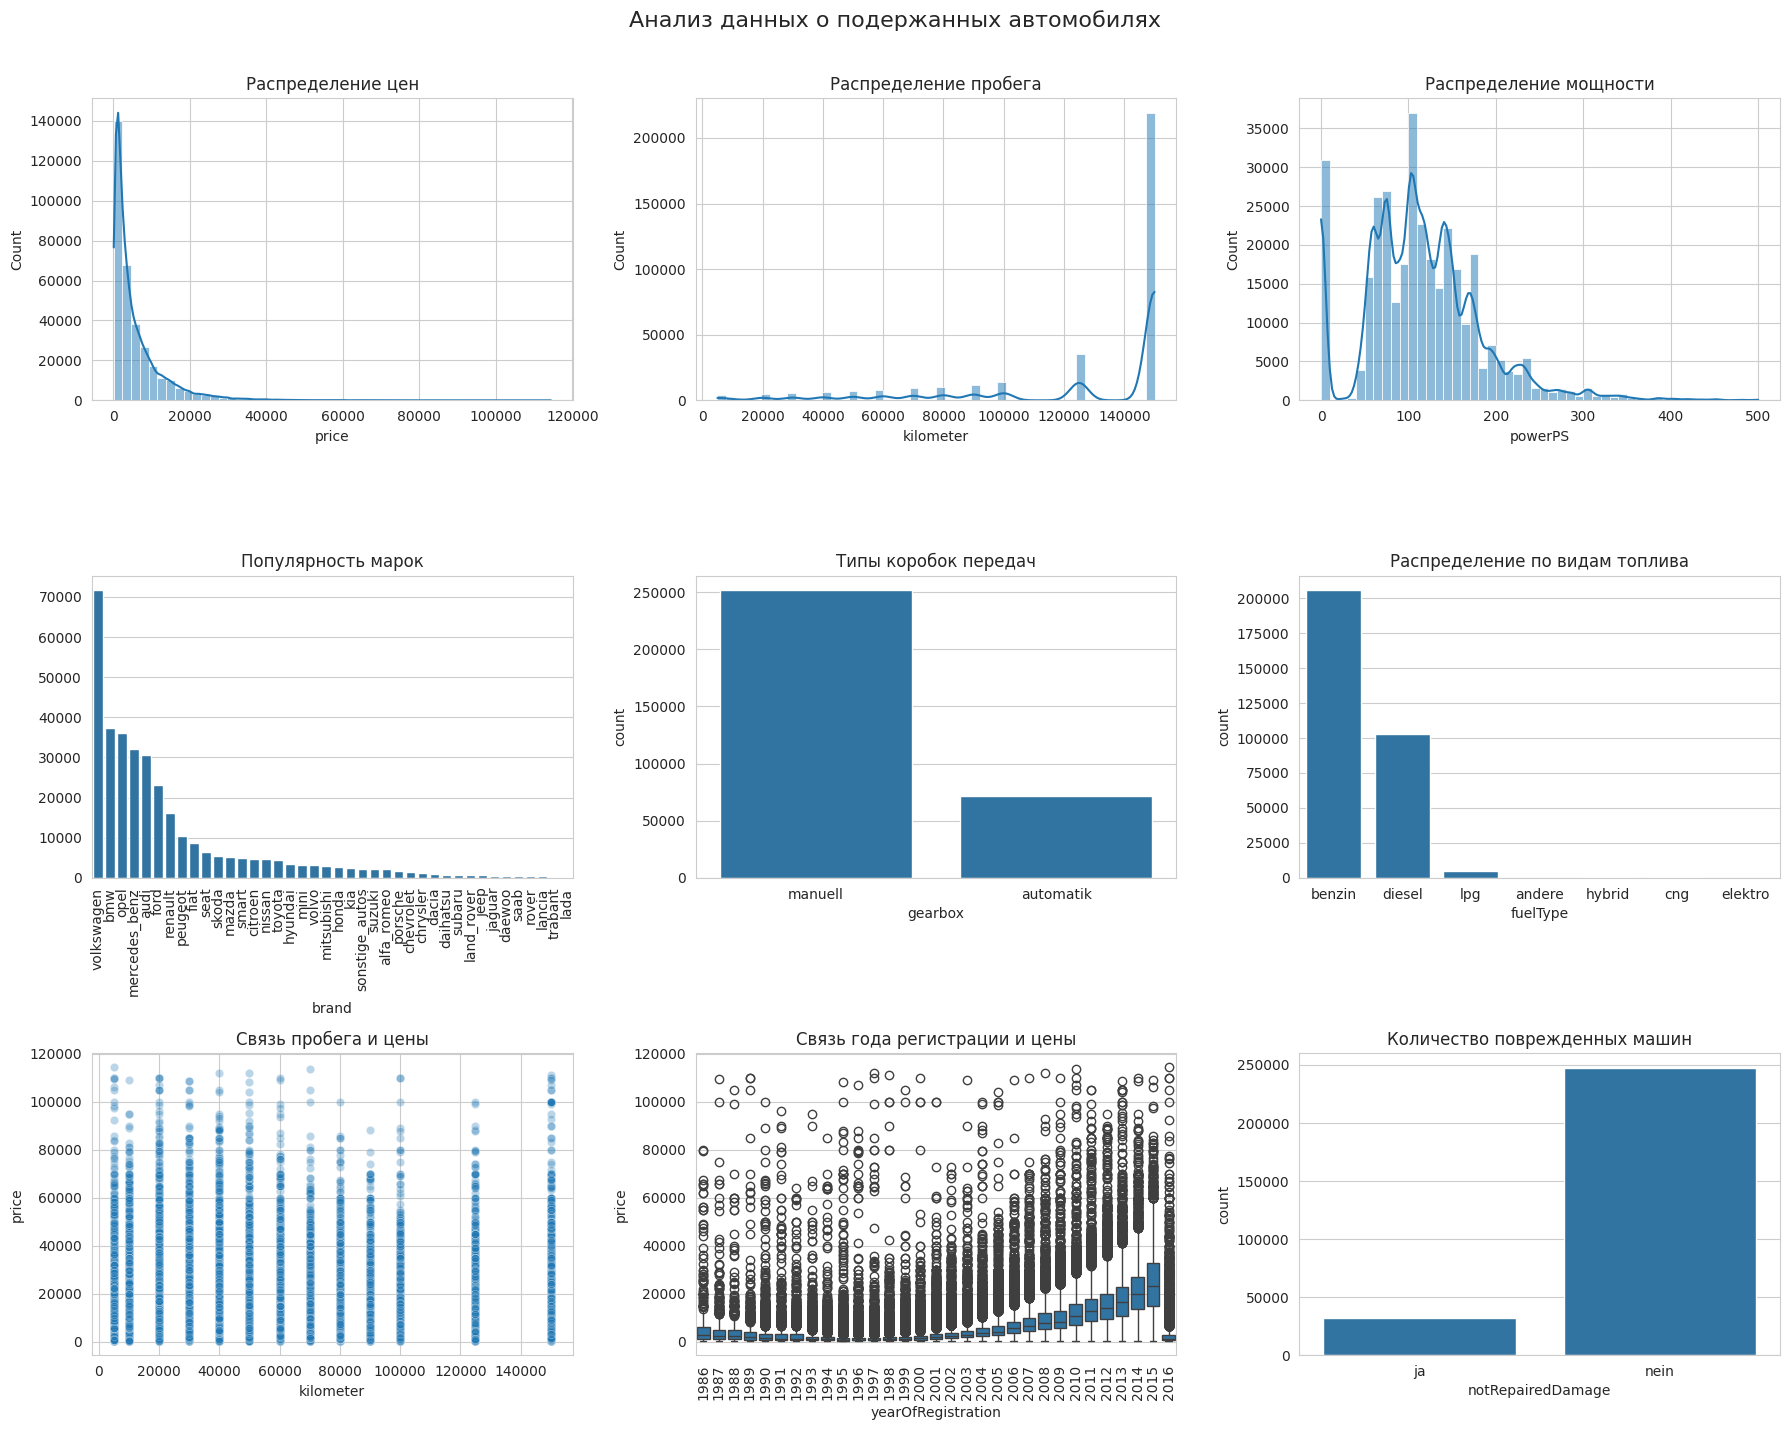

In [ ]:
# Настройка стиля для всех графиков
sns.set_style("whitegrid")
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle("Анализ данных о подержанных автомобилях", fontsize=16)

# 1. Гистограмма цен
sns.histplot(df["price"], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Распределение цен")

# 2. Гистограмма пробега
sns.histplot(df["kilometer"], bins=50, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Распределение пробега")

# 3. Гистограмма мощности двигателя
sns.histplot(df["powerPS"], bins=50, kde=True, ax=axes[0, 2])
axes[0, 2].set_title("Распределение мощности")

# 4. Популярность марок
brand_counts = df["brand"].value_counts()
sns.barplot(x=brand_counts.index, y=brand_counts.values, ax=axes[1, 0])
axes[1, 0].set_title("Популярность марок")
axes[1, 0].set_xticklabels(brand_counts.index, rotation=90)

# 5. Типы коробок передач
sns.countplot(x=df["gearbox"], ax=axes[1, 1])
axes[1, 1].set_title("Типы коробок передач")

# 6. Типы топлива
sns.countplot(x=df["fuelType"], ax=axes[1, 2])
axes[1, 2].set_title("Распределение по видам топлива")

# 7. Влияние пробега на цену
sns.scatterplot(x=df["kilometer"], y=df["price"], alpha=0.3, ax=axes[2, 0])
axes[2, 0].set_title("Связь пробега и цены")

# 8. Влияние года регистрации на цену
sns.boxplot(x=df["yearOfRegistration"], y=df["price"], ax=axes[2, 1])
axes[2, 1].set_title("Связь года регистрации и цены")
axes[2, 1].set_xticklabels(axes[2, 1].get_xticklabels(), rotation=90)

# 9. Количество поврежденных машин
sns.countplot(x=df["notRepairedDamage"], ax=axes[2, 2])
axes[2, 2].set_title("Количество поврежденных машин")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Лучшая степень полинома: 2
Средняя абсолютная ошибка: 2232.71
Коэффициент детерминации (R²): 0.67


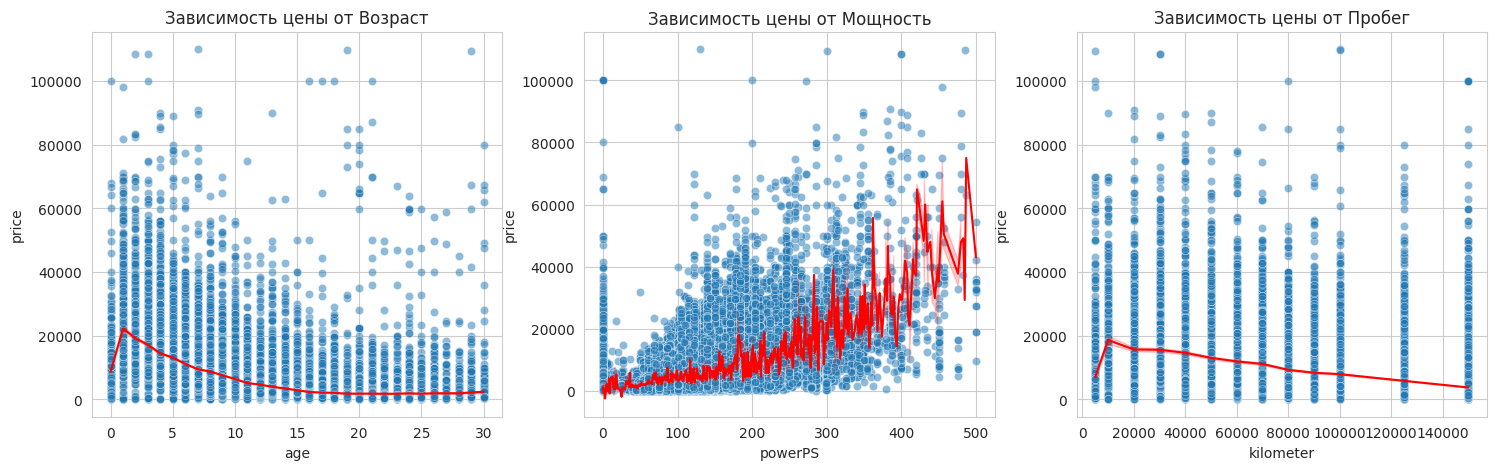

In [ ]:
columns = ["price", "yearOfRegistration", "powerPS", "kilometer"]
df = df[columns].dropna()

# Создаём новый признак - возраст автомобиля
current_year = 2016  # Данные собраны в 2016 году
df["age"] = current_year - df["yearOfRegistration"]
df = df[df["age"] >= 0]  # Исключаем некорректные данные

# Разделение данных
X = df[["age", "powerPS", "kilometer"]]
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Подбор оптимальной степени полинома
best_degree = 1
best_score = float("-inf")

for degree in range(1, 5):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    avg_score = np.mean(scores)

    if avg_score > best_score:
        best_score = avg_score
        best_degree = degree

# Обучение модели с лучшей степенью полинома
final_model = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

# Оценка модели
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Лучшая степень полинома: {best_degree}")
print(f"Средняя абсолютная ошибка: {mae:.2f}")
print(f"Коэффициент детерминации (R²): {r2:.2f}")

# Визуализация зависимостей
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
features = ["age", "powerPS", "kilometer"]
titles = ["Возраст", "Мощность", "Пробег"]

for i, feature in enumerate(features):
    sns.scatterplot(x=X_test[feature], y=y_test, alpha=0.5, ax=axes[i])
    sns.lineplot(x=X_test[feature], y=y_pred, color="red", ax=axes[i])
    axes[i].set_title(f"Зависимость цены от {titles[i]}")

plt.show()


## Работа с пропусками

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy="median")  # Для числовых данных
# df[num_cols] = imputer.fit_transform(df[num_cols])

In [ ]:
nans = df.isna().sum()
print(nans)

price                 0
yearOfRegistration    0
powerPS               0
kilometer             0
age                   0
dtype: int64


In [ ]:
na_cols = nans[nans != 0].index
na_cols

Index([], dtype='object')

### Признак 'model' сильно коррелировал с 'brand'. Удалим один из них

In [ ]:
# df.drop("brand", axis=1, inplace=True)

### 1. Просто удалим все строчки с пропусками

In [ ]:
df_del = df[~np.any(df.isna(), axis=1)]

### 2. Заменим на моду

In [ ]:
df_mode = df.fillna(df[na_cols].mode())

## Закодируем категориальные признаки (пока признак name убрал)
Ещё убрал признак 'brand', так как он очень сильно коррелировал с признаком 'model'

In [ ]:
# df_del = pd.get_dummies(df_del.drop('name', axis = 1), drop_first=True)
# df_mode = pd.get_dummies(df_mode.drop('name', axis = 1), drop_first=True)
# df = pd.get_dummies(df, columns=["fuelType", "gearbox", "vehicleType"], drop_first=True)

In [ ]:
# def get_months(df):
    # df["dateCrawled_month"] = df["dateCrawled"].dt.month
    # df["dateCreated_month"] = df["dateCreated"].dt.month
    # df["lastSeen_month"] = df["lastSeen"].dt.month
    # df.drop(["dateCrawled", "dateCreated", "lastSeen"], axis=1, inplace=True)


# get_months(df_del)
# get_months(df_mode)

## Корреляция

In [ ]:
corred = df_del.corr()

In [ ]:
corred.columns

Index(['price', 'yearOfRegistration', 'powerPS', 'kilometer', 'age'], dtype='object')

In [ ]:
for i in range(len(corred)):
    for j in range(i + 1, len(corred)):
        if abs(corred.iloc[i, j]) > 0.5:
            print(corred.columns[i], corred.columns[j], corred.iloc[i, j])
# corred.columns

price yearOfRegistration 0.5166544938575649
price powerPS 0.5550497146307488
price age -0.5166544938575574
yearOfRegistration age -0.9999999999999976


In [ ]:
# df_del.drop(["fuelType_diesel", 'dateCreated_month'], axis=1, inplace=True)
# df_mode.drop(["fuelType_diesel", 'dateCreated_month'], axis=1, inplace=True)

## Обучим лин регрессию

In [ ]:
scaler = StandardScaler()
x_ = scaler.fit_transform(df_del.drop('price', axis=1))

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
cat = CatBoostRegressor(verbose=False)

In [ ]:
lin_reg = cat
print('На удаленных строках:', cross_val_score(cat, x_, df_del['price'], scoring='neg_mean_absolute_error', cv=5).mean())
print('На заменённых модой:', cross_val_score(lin_reg, df_mode.drop('price', axis=1), df_mode['price'], scoring='neg_mean_squared_error').mean())

На удаленных строках: -1686.7364296601183
На заменённых модой: -11061000.864581557


In [ ]:
lin_reg = LinearRegression()
print('На удаленных строках:', cross_val_score(lin_reg, x_, df_del['price'], scoring='neg_mean_absolute_error', cv=5).mean())
print('На заменённых модой:', cross_val_score(lin_reg, df_mode.drop('price', axis=1), df_mode['price'], scoring='neg_mean_squared_error').mean())

На удаленных строках: -3078.704973548117
На заменённых модой: -24824523.391114794


In [ ]:
cat.fit(x_, df_del['price'])

In [ ]:
len(cat.feature_importances_)

4

In [ ]:
len(df_del.columns)

5

In [ ]:
sorted(list(zip(df_del.drop('price', axis=1).columns, cat.feature_importances_)), key = lambda x: -x[1])

[('powerPS', 45.688679190518926),
 ('yearOfRegistration', 19.170754245333313),
 ('age', 18.154516348550924),
 ('kilometer', 16.98605021559682)]

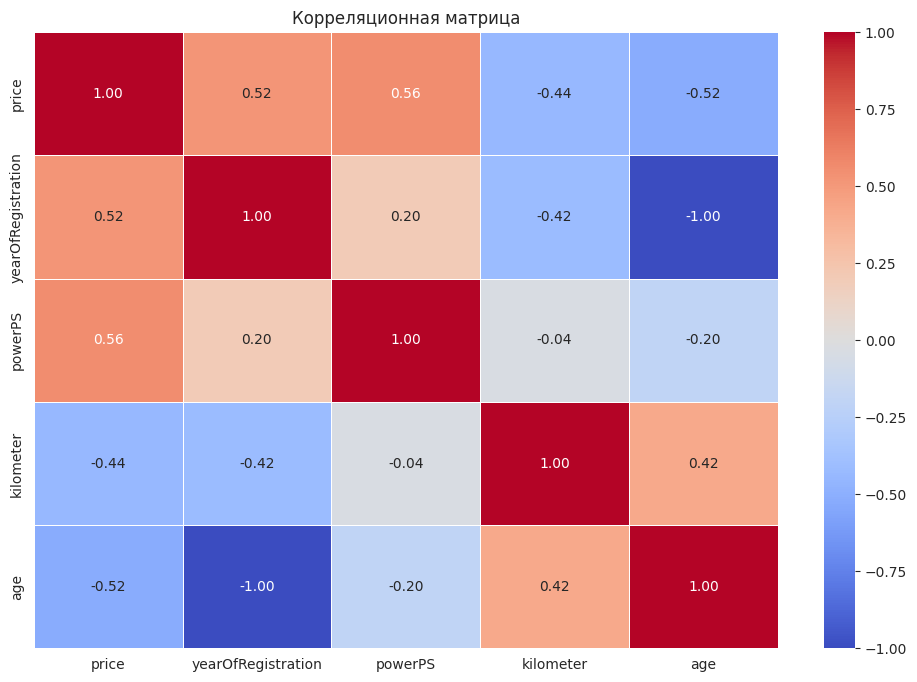

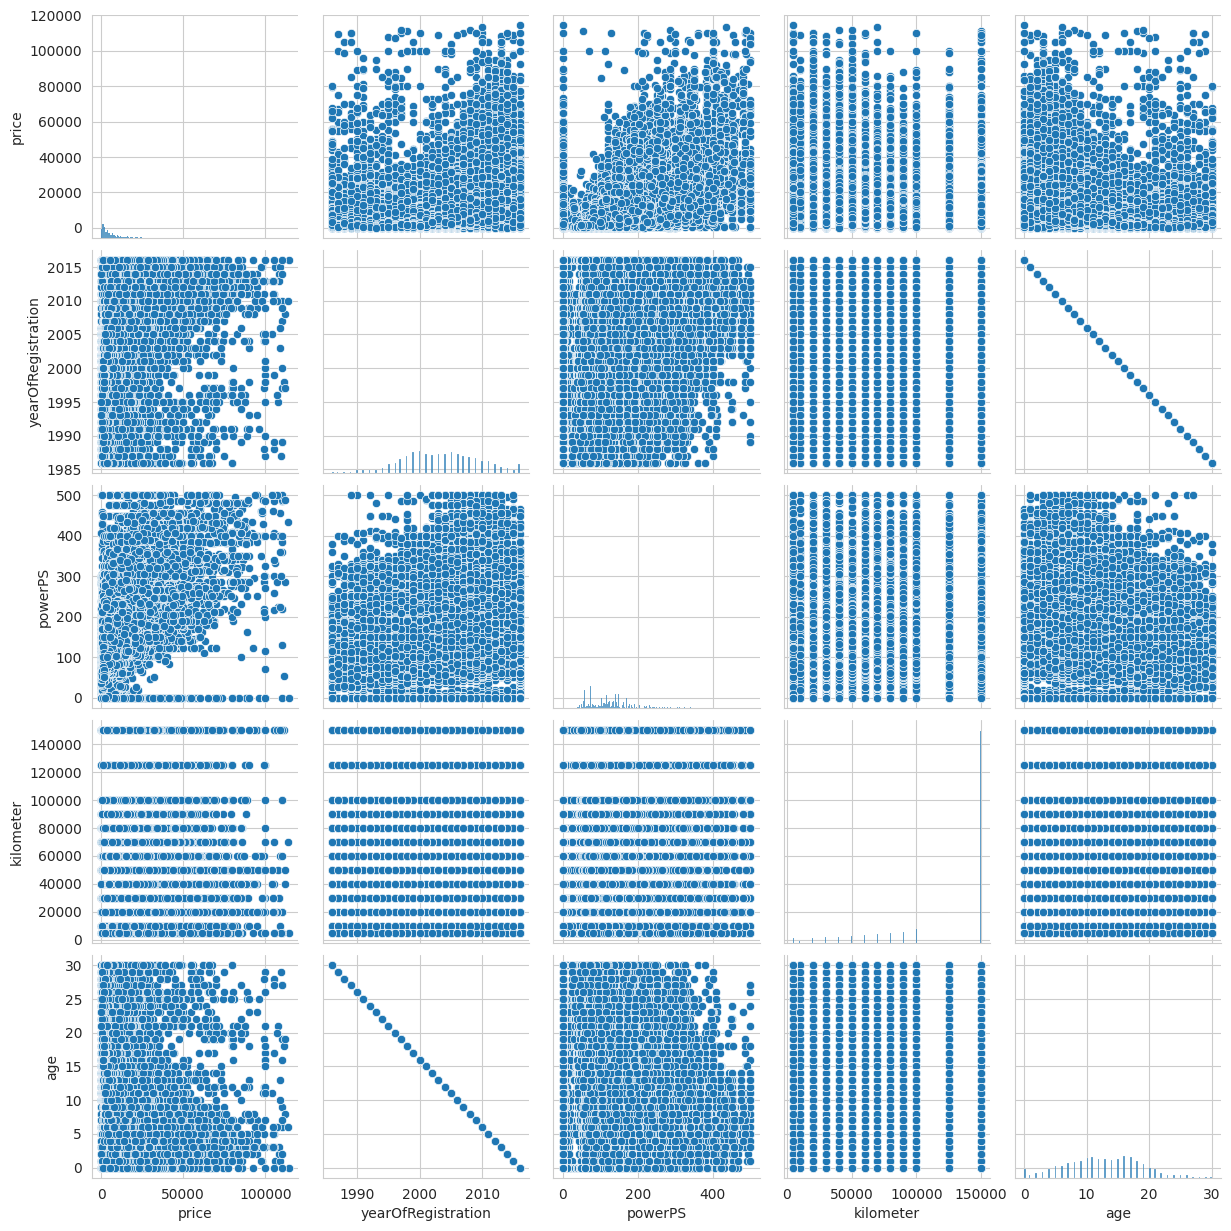

In [ ]:
# Построение корреляционной матрицы
corr_matrix = df.corr()

# Визуализация heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Корреляционная матрица')
plt.show()

# Построение pairplot для числовых данных
sns.pairplot(df)
plt.show()

In [ ]:
# Анализ сезонности
if 'dateCrawled' in df.columns:
    df['dateCrawled'] = pd.to_datetime(df['dateCrawled'])
    df.set_index('dateCrawled', inplace=True)
    df['price'].resample('M').mean().plot(title='Средняя цена по месяцам')
    plt.show()

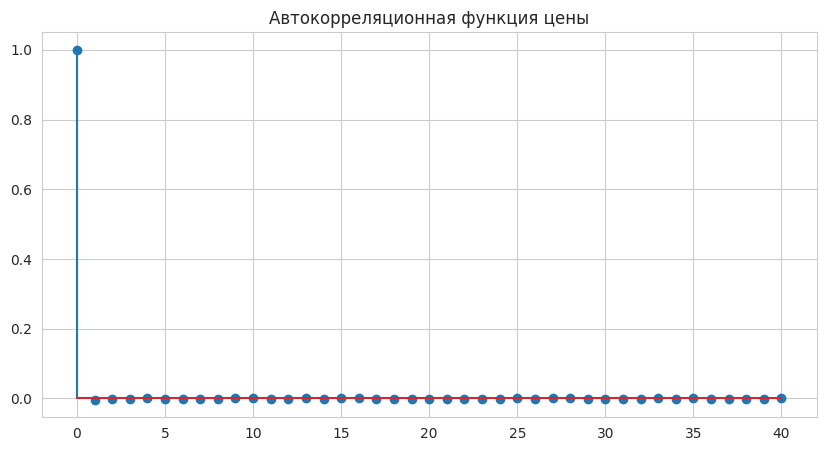

In [ ]:
from statsmodels.tsa.stattools import acf

# Проверка автокорреляции
if 'price' in df.columns:
    acf_values = acf(df['price'].dropna(), nlags=40)
    plt.figure(figsize=(10, 5))
    plt.stem(acf_values)
    plt.title('Автокорреляционная функция цены')
    plt.show()

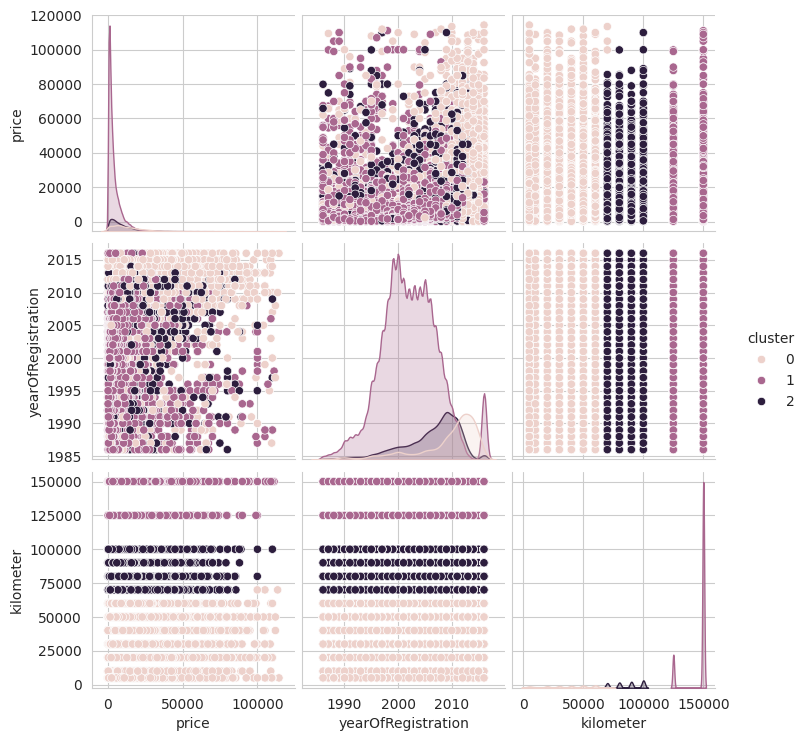

In [ ]:
# Кластеризация автомобилей по цене, году и пробегу
if all(col in df.columns for col in ['price', 'yearOfRegistration', 'kilometer']):
    cluster_data = df[['price', 'yearOfRegistration', 'kilometer']].dropna()
    kmeans = KMeans(n_clusters=3, random_state=42)
    cluster_data['cluster'] = kmeans.fit_predict(cluster_data)
    sns.pairplot(cluster_data, hue='cluster')
    plt.show()

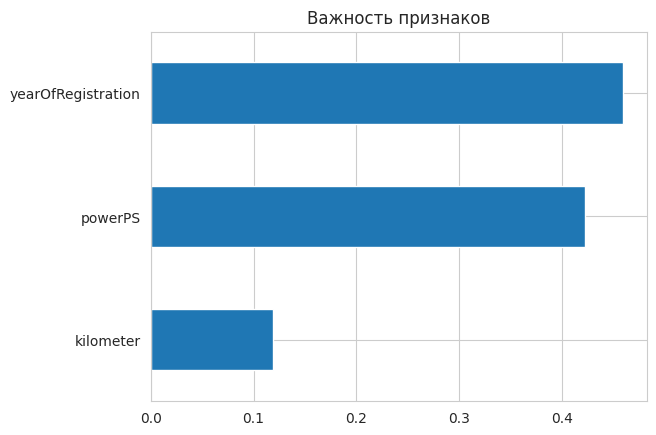

In [ ]:
# Обучение случайного леса для выявления важности признаков
if all(col in df.columns for col in ['price', 'powerPS', 'yearOfRegistration', 'kilometer']):
    df = df[['powerPS', 'yearOfRegistration', 'kilometer', 'price']].dropna()
    X = df[['powerPS', 'yearOfRegistration', 'kilometer']]
    y = df['price']

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importance = pd.Series(model.feature_importances_, index=X.columns)
    feature_importance.sort_values().plot(kind='barh', title='Важность признаков')
    plt.show()

In [ ]:
# Поиск полиномиальных зависимостей
if all(col in df.columns for col in ['price', 'powerPS', 'kilometer']):
    poly_features = ['powerPS', 'kilometer']
    poly_degree = 2

    X_poly = df[poly_features].dropna()
    y_poly = df.loc[X_poly.index, 'price']

    X_train, X_test, y_train, y_test = train_test_split(X_poly, y_poly, test_size=0.2, random_state=42)

    model_poly = make_pipeline(PolynomialFeatures(degree=poly_degree), LinearRegression())
    model_poly.fit(X_train, y_train)

    y_pred = model_poly.predict(X_test)

    print(f'R^2 score for polynomial regression (degree {poly_degree}):', r2_score(y_test, y_pred))

plt.show()


R^2 score for polynomial regression (degree 2): 0.5661158163476687
